In [16]:
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.models import *

from PIL import Image

from tqdm import tqdm

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

In [17]:
train_directory = 'data/training/'
valid_directory = 'data/validation/'
test_directory  = 'data/files_for_testing/'

In [18]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 7, figsize=(30, 30))  
    axes = axes.flatten() 
    for img, label, ax in zip(images_arr, labels, axes): 
        ax.imshow(img)  
        ax.set_title(label)
        ax.axis('off') 
    plt.tight_layout()  
    plt.show()  

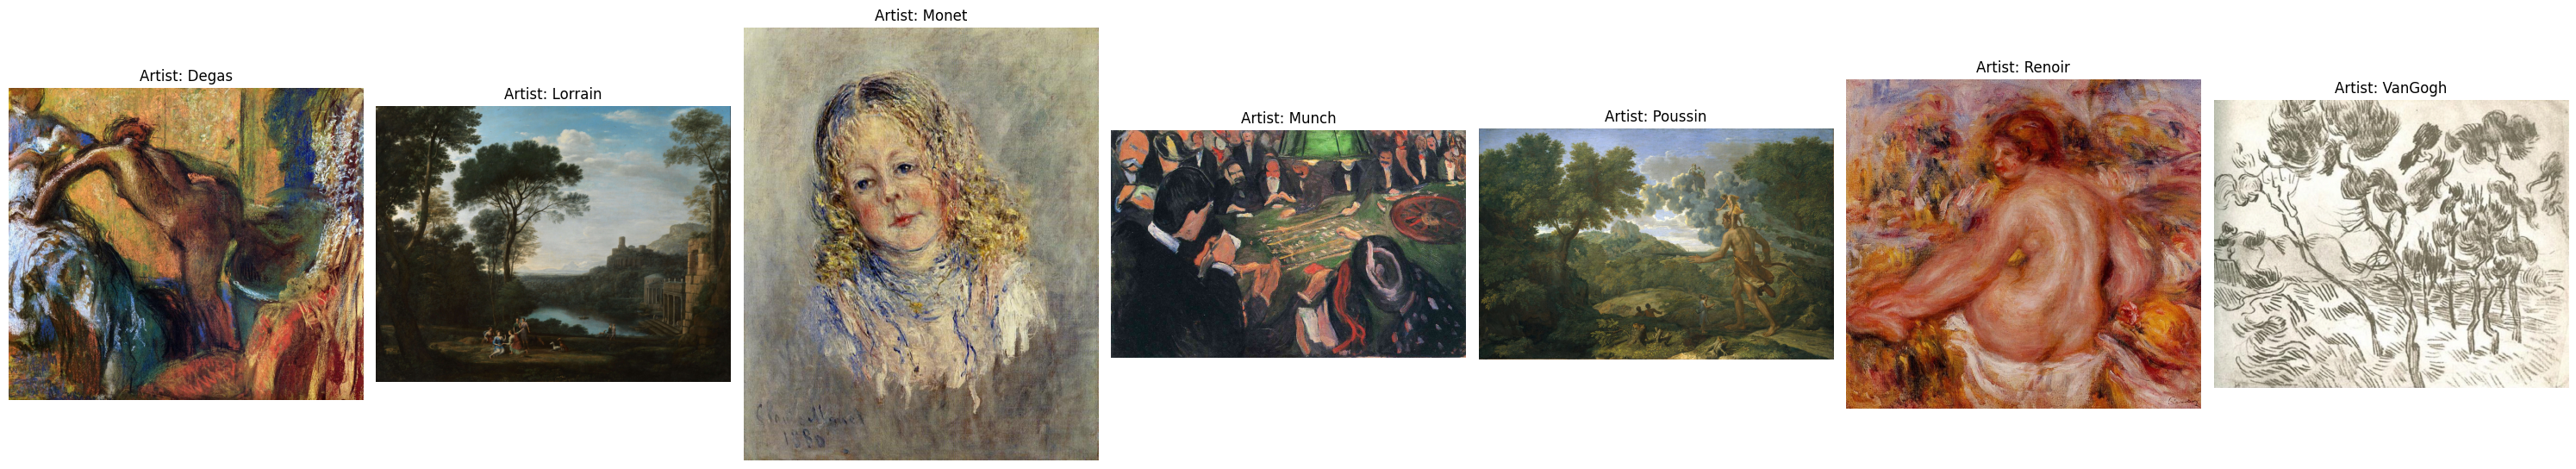

In [19]:
images_arr = []
labels = []

painters = [d for d in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, d))]
for painter in painters:
    tr_directory = os.path.join(train_directory, painter)
    image_files = [filename for filename in os.listdir(tr_directory) if filename.endswith('.jpg')]
    if image_files: 
        img = Image.open(os.path.join(tr_directory, image_files[12]))
        images_arr.append(img)
        labels.append("Artist: " + painter)

plotImages(images_arr, labels)

In [20]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [21]:
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

In [22]:
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
print(f"Rozmiary datasetów: {dataset_sizes}")

Rozmiary datasetów: {'train': 4352, 'valid': 1159, 'test': 295}


In [23]:
class_names = dataset['train'].classes
print("Klasy:", class_names)

Klasy: ['Degas', 'Lorrain', 'Monet', 'Munch', 'Poussin', 'Renoir', 'VanGogh']


In [24]:
from collections import Counter

class_labels = dataset['train'].targets
class_counts = Counter(class_labels)

In [25]:
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
class_counts_df['Class Name'] = [class_names[idx] for idx in class_counts_df['Class']]
class_counts_df['Class Weight'] = class_counts_df['Count'].sum() / (class_counts_df['Count'] * class_counts_df.shape[0])

print("Liczność klas w zbiorze treningowym:")
print(class_counts_df)

Liczność klas w zbiorze treningowym:
   Class  Count Class Name  Class Weight
0      0    469      Degas      1.325617
1      1     77    Lorrain      8.074212
2      2   1025      Monet      0.606551
3      3    146      Munch      4.258317
4      4    129    Poussin      4.819491
5      5   1059     Renoir      0.587077
6      6   1447    VanGogh      0.429657


In [26]:
class_weights = {idx: weight for idx, weight in enumerate(class_counts_df['Class Weight'])}
print("Wagi klas:", class_weights)

Wagi klas: {0: 1.325616813889735, 1: 8.074211502782932, 2: 0.6065505226480836, 3: 4.258317025440313, 4: 4.819490586932448, 5: 0.5870767570484284, 6: 0.42965741929114426}


In [27]:
from torch.utils.data import DataLoader, WeightedRandomSampler

sample_weights = [class_weights[label] for label in class_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [28]:
batch_size = 64
train_loader = DataLoader(dataset['train'], batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

print("DataLoader przygotowany.")

DataLoader przygotowany.


In [29]:
from sklearn.utils.class_weight import compute_class_weight
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model = models.vgg19(pretrained=True) 
n_classes = len(dataset['train'].classes)  

for name, param in model.named_parameters():
    if 'features.36' in name or 'features.37' in name or 'classifier' in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, n_classes)
)

def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)

model.classifier.apply(initialize_weights)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=torch.arange(n_classes).numpy(),
    y=dataset['train'].targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)


c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
from sklearn.metrics import f1_score, precision_score, recall_score

def train_model_with_tracking(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, log_interval=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    early_stopping_patience = 20
    early_stopping_counter = 0

    metrics_history = {
        'train_loss': [],
        'valid_loss': [],
        'train_f1': [],
        'valid_f1': [],
        'train_precision': [],
        'valid_precision': [],
        'train_recall': [],
        'valid_recall': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            y_true = []
            y_pred = []

            loop = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=f'{phase} Phase')
            for batch_idx, (inputs, labels) in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='weighted')
            epoch_precision = precision_score(y_true, y_pred, average='weighted')
            epoch_recall = recall_score(y_true, y_pred, average='weighted')

            if phase == 'train':
                metrics_history['train_loss'].append(epoch_loss)
                metrics_history['train_f1'].append(epoch_f1)
                metrics_history['train_precision'].append(epoch_precision)
                metrics_history['train_recall'].append(epoch_recall)
            else:
                metrics_history['valid_loss'].append(epoch_loss)
                metrics_history['valid_f1'].append(epoch_f1)
                metrics_history['valid_precision'].append(epoch_precision)
                metrics_history['valid_recall'].append(epoch_recall)

            print(f'{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

            if phase == 'valid':
                scheduler.step(epoch_f1)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        return model, metrics_history

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best F1: {best_f1:.4f}')

    model.load_state_dict(best_model_wts)
    return model, metrics_history

dataloaders = {'train': train_loader, 'valid': valid_loader}
model, metrics_history = train_model_with_tracking(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)


Epoch 0/19
----------


train Phase: 100%|██████████| 68/68 [03:02<00:00,  2.69s/it]


train Loss: 0.6901 F1: 0.4533 Precision: 0.5865 Recall: 0.5046


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.64s/it]


valid Loss: 1.2519 F1: 0.4160 Precision: 0.7653 Recall: 0.3770
Epoch 1/19
----------


train Phase: 100%|██████████| 68/68 [03:02<00:00,  2.68s/it]


train Loss: 0.6786 F1: 0.4951 Precision: 0.6093 Recall: 0.5280


valid Phase: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]


valid Loss: 1.0656 F1: 0.5011 Precision: 0.7920 Recall: 0.4478
Epoch 2/19
----------


train Phase: 100%|██████████| 68/68 [03:11<00:00,  2.82s/it]


train Loss: 0.6179 F1: 0.5363 Precision: 0.6341 Recall: 0.5639


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 1.0127 F1: 0.5296 Precision: 0.7902 Recall: 0.4832
Epoch 3/19
----------


train Phase: 100%|██████████| 68/68 [03:00<00:00,  2.66s/it]


train Loss: 0.5820 F1: 0.5478 Precision: 0.6347 Recall: 0.5770


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.67s/it]


valid Loss: 0.9249 F1: 0.5887 Precision: 0.7834 Recall: 0.5522
Epoch 4/19
----------


train Phase: 100%|██████████| 68/68 [03:03<00:00,  2.69s/it]


train Loss: 0.5363 F1: 0.5954 Precision: 0.6747 Recall: 0.6174


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.67s/it]


valid Loss: 0.8940 F1: 0.6296 Precision: 0.7704 Recall: 0.5971
Epoch 5/19
----------


train Phase: 100%|██████████| 68/68 [03:01<00:00,  2.68s/it]


train Loss: 0.5722 F1: 0.5763 Precision: 0.6561 Recall: 0.5981


valid Phase: 100%|██████████| 19/19 [00:32<00:00,  1.71s/it]


valid Loss: 0.9029 F1: 0.5864 Precision: 0.7910 Recall: 0.5453
Epoch 6/19
----------


train Phase: 100%|██████████| 68/68 [03:00<00:00,  2.65s/it]


train Loss: 0.5093 F1: 0.5944 Precision: 0.6698 Recall: 0.6176


valid Phase: 100%|██████████| 19/19 [00:32<00:00,  1.70s/it]


valid Loss: 0.8537 F1: 0.6016 Precision: 0.7890 Recall: 0.5651
Epoch 7/19
----------


train Phase: 100%|██████████| 68/68 [03:02<00:00,  2.69s/it]


train Loss: 0.4805 F1: 0.6187 Precision: 0.6905 Recall: 0.6365


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


valid Loss: 0.8461 F1: 0.6289 Precision: 0.7972 Recall: 0.5858
Epoch 8/19
----------


train Phase: 100%|██████████| 68/68 [03:00<00:00,  2.65s/it]


train Loss: 0.4744 F1: 0.6231 Precision: 0.6848 Recall: 0.6404


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


valid Loss: 0.7840 F1: 0.6525 Precision: 0.7867 Recall: 0.6204
Epoch 9/19
----------


train Phase: 100%|██████████| 68/68 [03:01<00:00,  2.67s/it]


train Loss: 0.4786 F1: 0.6270 Precision: 0.6828 Recall: 0.6450


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.7794 F1: 0.6574 Precision: 0.7935 Recall: 0.6281
Epoch 10/19
----------


train Phase: 100%|██████████| 68/68 [02:56<00:00,  2.60s/it]


train Loss: 0.4537 F1: 0.6394 Precision: 0.6969 Recall: 0.6546


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


valid Loss: 0.8509 F1: 0.6619 Precision: 0.8260 Recall: 0.6083
Epoch 11/19
----------


train Phase: 100%|██████████| 68/68 [03:04<00:00,  2.72s/it]


train Loss: 0.4491 F1: 0.6478 Precision: 0.7041 Recall: 0.6625


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.7662 F1: 0.6864 Precision: 0.8119 Recall: 0.6488
Epoch 12/19
----------


train Phase: 100%|██████████| 68/68 [03:01<00:00,  2.66s/it]


train Loss: 0.4359 F1: 0.6665 Precision: 0.7209 Recall: 0.6801


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.6539 F1: 0.6897 Precision: 0.7971 Recall: 0.6670
Epoch 13/19
----------


train Phase: 100%|██████████| 68/68 [02:58<00:00,  2.62s/it]


train Loss: 0.4588 F1: 0.6503 Precision: 0.7087 Recall: 0.6629


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


valid Loss: 0.6888 F1: 0.7151 Precision: 0.8141 Recall: 0.6877
Epoch 14/19
----------


train Phase: 100%|██████████| 68/68 [02:54<00:00,  2.57s/it]


train Loss: 0.4787 F1: 0.6529 Precision: 0.7023 Recall: 0.6652


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.7046 F1: 0.6861 Precision: 0.8200 Recall: 0.6531
Epoch 15/19
----------


train Phase: 100%|██████████| 68/68 [03:00<00:00,  2.65s/it]


train Loss: 0.4407 F1: 0.6639 Precision: 0.7133 Recall: 0.6756


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.6725 F1: 0.7092 Precision: 0.8117 Recall: 0.6799
Epoch 16/19
----------


train Phase: 100%|██████████| 68/68 [03:00<00:00,  2.66s/it]


train Loss: 0.4293 F1: 0.6732 Precision: 0.7245 Recall: 0.6850


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


valid Loss: 0.6362 F1: 0.6912 Precision: 0.8012 Recall: 0.6747
Epoch 17/19
----------


train Phase: 100%|██████████| 68/68 [03:03<00:00,  2.70s/it]


train Loss: 0.4184 F1: 0.6688 Precision: 0.7187 Recall: 0.6806


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.65s/it]


valid Loss: 0.5911 F1: 0.7244 Precision: 0.8239 Recall: 0.6972
Epoch 18/19
----------


train Phase: 100%|██████████| 68/68 [03:01<00:00,  2.67s/it]


train Loss: 0.4364 F1: 0.6774 Precision: 0.7236 Recall: 0.6880


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


valid Loss: 0.6031 F1: 0.7176 Precision: 0.8093 Recall: 0.6980
Epoch 19/19
----------


train Phase: 100%|██████████| 68/68 [02:57<00:00,  2.61s/it]


train Loss: 0.3809 F1: 0.6952 Precision: 0.7369 Recall: 0.7061


valid Phase: 100%|██████████| 19/19 [00:31<00:00,  1.66s/it]

valid Loss: 0.6348 F1: 0.7160 Precision: 0.8223 Recall: 0.6894
Training complete in 71m 1s
Best F1: 0.7244


In [54]:
torch.save(model, 'model_vgg19.pth')
print("Model został zapisany jako 'model_vgg19.pth'")

Model został zapisany jako 'model_vgg19.pth'


In [3]:
model = torch.load('model_vgg19.pth')
model.eval()  
print("Model został wczytany i jest gotowy do użycia.")


Model został wczytany i jest gotowy do użycia.


In [56]:
import gzip
import shutil

gz_model_path = 'model_vgg19.pth.gz'
model_path = 'model_vgg19.pth'

with open(model_path, 'rb') as f_in:
    with gzip.open(gz_model_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Model został skompresowany jako {gz_model_path}")

Model został skompresowany jako model_vgg19.pth.gz


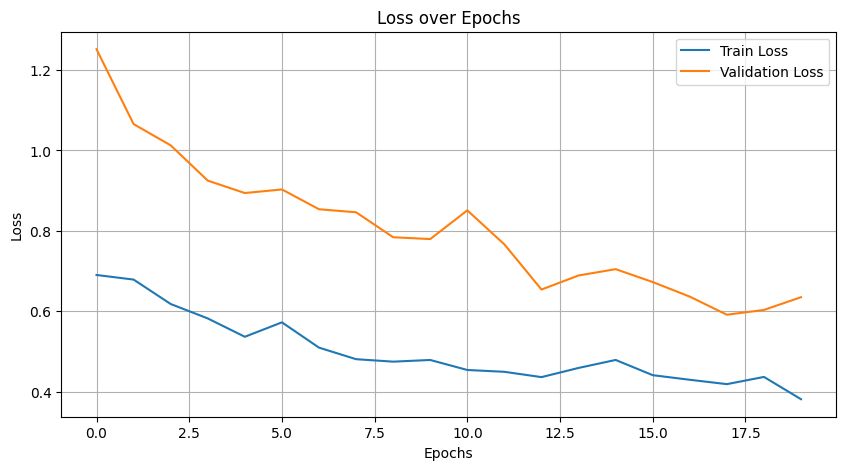

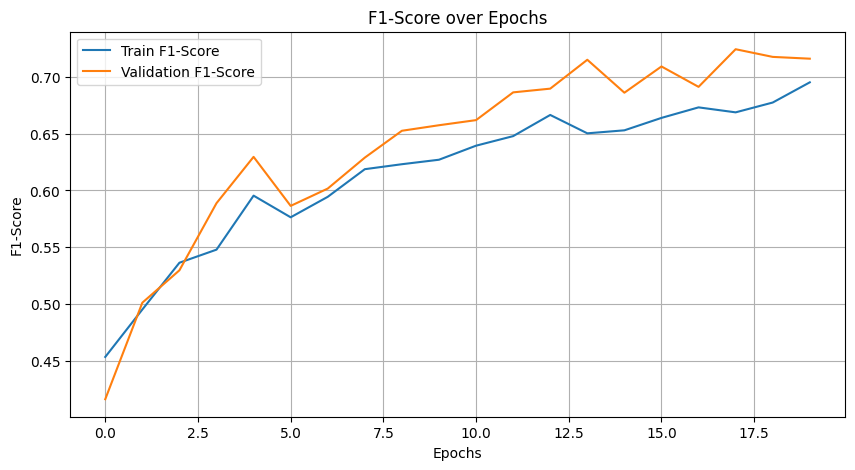

In [57]:
def plot_metrics(metrics_history):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_history['train_loss'], label='Train Loss')
    plt.plot(metrics_history['valid_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(metrics_history['train_f1'], label='Train F1-Score')
    plt.plot(metrics_history['valid_f1'], label='Validation F1-Score')
    plt.title('F1-Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(metrics_history)

In [58]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset['test'].classes))


Accuracy: 0.7695
F1-Score: 0.7925
Classification Report:
              precision    recall  f1-score   support

       Degas       0.75      0.84      0.79        32
     Lorrain       0.23      1.00      0.38         6
       Monet       0.82      0.87      0.85        69
       Munch       0.33      0.90      0.49        10
     Poussin       0.71      1.00      0.83        10
      Renoir       0.94      0.70      0.81        71
     VanGogh       0.98      0.67      0.80        97

    accuracy                           0.77       295
   macro avg       0.68      0.86      0.71       295
weighted avg       0.86      0.77      0.79       295



In [32]:
name = class_names

In [ ]:
import torch

model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)  
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

accuracy = 100 * correct / total
print(f"Prediction accuracy on train data = {accuracy:.2f}%")


Prediction accuracy on train data = 73.32%


In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in valid_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)  
        correct += (predicted == labels).sum().item() 

accuracy = 100 * correct / total
print(f"Prediction accuracy on validation data = {accuracy:.2f}%")


Prediction accuracy on validation data = 69.72%


In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Dokładność klasyfikacji na zbiorze testowym = {accuracy:.2f}%")

Dokładność klasyfikacji na zbiorze testowym = 76.95%


In [33]:
name

['Degas', 'Lorrain', 'Monet', 'Munch', 'Poussin', 'Renoir', 'VanGogh']

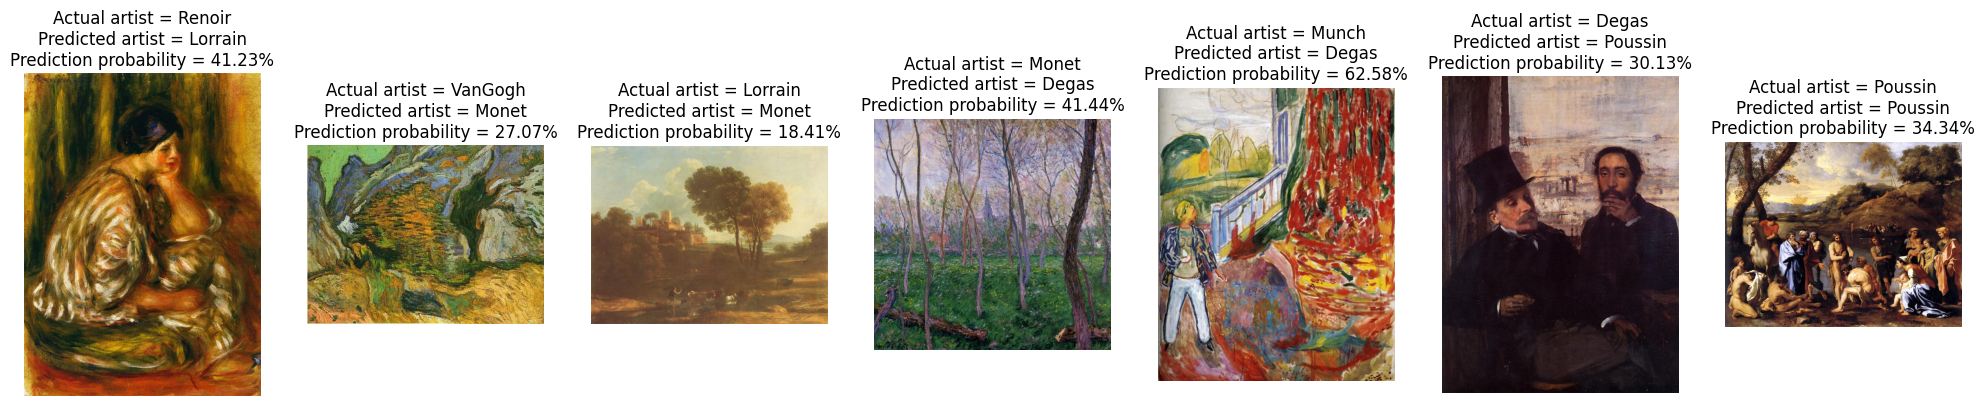

In [36]:
from keras.preprocessing.image import load_img, img_to_array
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))

unique_artists = set()

while len(unique_artists) < n:
    random_artist = random.choice(name)
    unique_artists.add(random_artist)

for i, random_artist in enumerate(unique_artists):
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = load_img(random_image_file, target_size=(224, 224))  
    test_image = img_to_array(test_image)
    test_image /= 255.0 
    test_image = np.expand_dims(test_image, axis=0) 

    test_tensor = torch.tensor(test_image, device=device).permute(0, 3, 1, 2)  

    with torch.no_grad():
        prediction = model(test_tensor)
        prediction_probability = torch.max(torch.softmax(prediction, dim=1)).item()
        prediction_idx = torch.argmax(prediction, dim=1).item()

    labels = {idx: class_name for idx, class_name in enumerate(dataset['train'].classes)}

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f}%" \
        .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '), prediction_probability * 100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()                                                                                              
